Names: Kolt Byers, McHale Trotter

# Modeling Circular Standing Waves
In this project, we aim to model circular standing waves. We will use our typical ball and spring model to calculate and animate the movement of our circular ring.

## Background
What is a standing wave?

* A standing wave is a vibration of a system in which some particular points remain fixed while others between them vibrate with the maximum amplitude.

What is the difference between a linear system and a circular system?

* In a linear system the string displaces mostly over the y-axis. In a circular model, it displaces radially away from the center of the circle. This means that our calculations need to use a polar coordinate system instead of cartesian coordinates system.

Circular Standing Wave Example:
https://youtu.be/df3oJPi9_mg?t=64

# Simulation
We initialized our circle to have a radius of 10 meters. The position of our atoms is determined by the value of N and are placed radially around the center of the circle.

dtheta = 2π/(N+1)

The x and y values of the atoms are then created to plot in the cartesian plane.

x = (r+2*ui)np.cos(theta)

y = (r+2*ui)np.sin(theta)

## Assumptions

Our model exists in a vacuum, there is no gravitational field or air resistence effecting our results.

## Import All Files Needed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from vpython import * 
from scipy.linalg import eigh
from IPython.display import display, Markdown, Latex
from IPython.display import HTML
from mplEasyAnimate import animation
from tqdm import tqdm
from base64 import b64encode

<IPython.core.display.Javascript object>

## Function For Finding Eigen Values

In [2]:
def geteigen():
    """Calculate eigenvalues and eigenvectors for N coupled oscillators
    
    Keyword arguments: None
    
    Global variables: N, k
    
    Returns: frequences, array of eigenvectors
    """
    
    #Build matrices
    A=np.zeros((N,N))

    for i in range(N):
        A[i,i] = 2*k
        if i==0:
            A[0,i+1]=-k
        elif i==N-1:
            A[i,i-1]=-k
        else:
            A[i,i-1]=-k
            A[i,i+1]=-k

    B=m*np.identity(N)

    #find eigenvalues and eigenvectors
    lamb, a = eigh(A, B) # eigenvalues and eigenvectors
    omegas = np.sqrt(lamb) #frequencies
    
    return omegas, a

## Initialize Variables

In [3]:
#global variables

#properties of the system
M = 12.0 #mass of string in kg
L = 10.0 #length of string in m
K = 1.0 #effective stiffness in N/m
N = 200 #number of masses

#properties of each mass
m = M/N
L0 = L/(N+1)
k = K*(N+1)

dtheta = 2*np.pi/(N+1)

## Obtain Omegas and 'a' value

In [4]:
omegas, a = geteigen()

## Calculate Time and Displacements of Each Atom

In [5]:
def get_u_t(ui, omegas, a, ttotal):
    """Calculate u(t) for all masses. u(t) is a 2D array. The first column is for time. 
    Column i is for the displacement of mass i, with i = 1, 2, ... N. Return u, C where C is an array of coefficients.

    Keyword arguments:
    
    ui -- array of displacements of masses u_i at t = 0.
    omegas -- frequencies
    a -- eigenvectors
    ttotal -- total time for calculations of u(t)
    """
    
    #calculate coefficients using initial conditions
    C = np.linalg.solve(a,ui)

    #build the general solution
    h = 0.01
#    ttotal = 20
    t = np.arange(0,ttotal,h)

    #build array u that contains time in the first column and displacement of each mass in subsequent columns
    u = np.zeros((len(t),N+1))
    u[:,0] = np.transpose(t) #store time in first column, u_i in other columns

    for i in range(N):
        for w in range(0,len(omegas)):
            u[:,i+1] = u[:,i+1] + C[w]*a[i,w]*np.cos(omegas[w]*t)

    return u, C

## Create Initial Circle

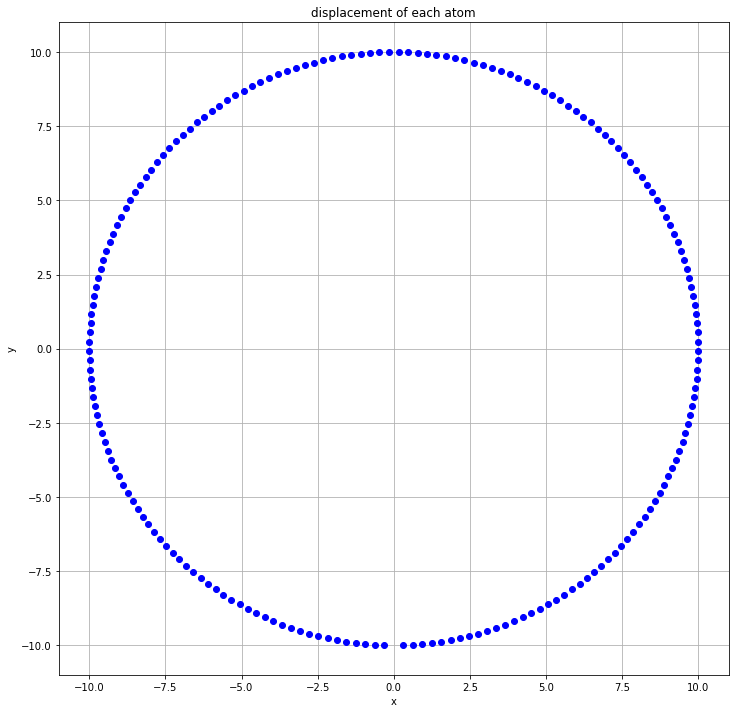

In [6]:
r = 10
theta = np.arange(-np.pi/2+dtheta, 3*np.pi/2, dtheta)
i = 0

#initial displacement of the masses 
ui = np.zeros(N)

ttotal = 20 #total time of evolution
u, C = get_u_t(ui, omegas, a, ttotal)

x = (r+2*ui)*np.cos(theta)
y = (r+2*ui)*np.sin(theta)

plt.figure(figsize=(12,12))
plt.title("displacement of each atom")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x,y, 'bo')
plt.grid()
plt.show()

# Calculating the Mode and Displacements of Each Atom

In [7]:
def plotmode (mode, omegas, a):
    
    h = 0.01
    ttotal = 20 #total time for calculations

    # array of times
    t = np.arange(0,ttotal,h)

    # build data array with all data; u[:,0] is time; other columns are u_i for each atom i
    u = np.zeros((int(ttotal/h), N+1))

    u[:,0] = np.transpose(t) #t.T

    for i in range(N):
        u_atom = a[i,mode]*np.cos(omegas[mode]*t)
        u[:,i+1] = np.transpose(u_atom)[:]
        
    # plot
    plt.figure(figsize=(12,8))
    plt.title("displacement of each atom")
    plt.xlabel("t (s)")
    plt.ylabel("$u_i$ (m)")
    for i in range(N): #plot each atom
        plt.plot(u[:,0], u[:,i+1])
    plt.grid()
    plt.show()
    
    return u

# Plot mode 1

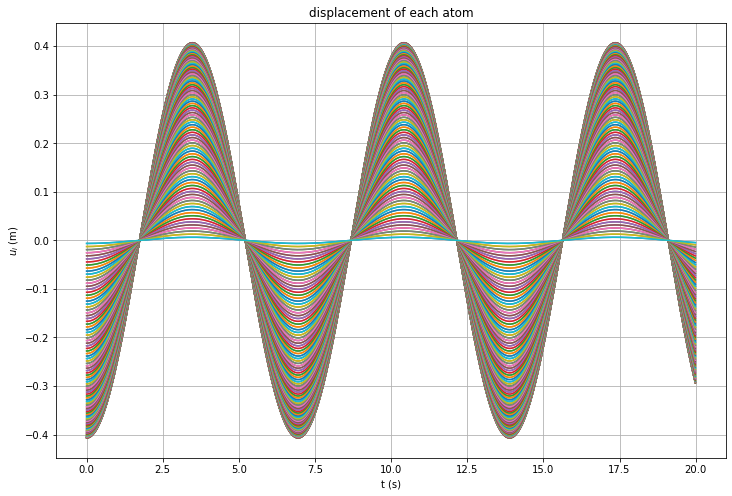

In [8]:
u = plotmode(0,omegas,a)

In [9]:
def animate_matplotlib(filename, u, skip):

    #copy column 1 to last column if a new array
    u_comp = np.zeros((len(u[:,0]), N+3))
    u_comp[:,0] = u[:,0] #copy time column
    u_comp[:,2:-1] = u[:,1:] #copy all of u (except time) to columns 2 through second to last column
    theta_comp = np.zeros(N+2)
    theta_comp[0] = -np.pi/2
    theta_comp[-1] = 3*pi/2
    theta_comp[1:-1] = theta[:]

    Niterations = len(u[:,0])

    with animation(filename, fps=30) as anim:
        t_offsets = np.arange(Niterations)
        i=0
        for offset in tqdm(t_offsets):

            if i>=0 and i % (skip-1) == 0:
                fig = plt.figure(figsize=(12, 12), dpi=72)
                # plot
                plt.title("displacement of each atom")
                plt.xlabel("x (m)")
                plt.ylabel("$u(t_total)$ (m)")
                x = (r+u_comp[i,1:])*np.cos(theta_comp)
                y = (r+u_comp[i,1:])*np.sin(theta_comp)
                plt.plot(x, y,'bo-')
                plt.xlim(-20,20)
                plt.ylim(-20,20)
                plt.grid()
                anim.add_frame(fig)
                plt.close(fig)
            i=i+1

# Plot/Animate mode 2

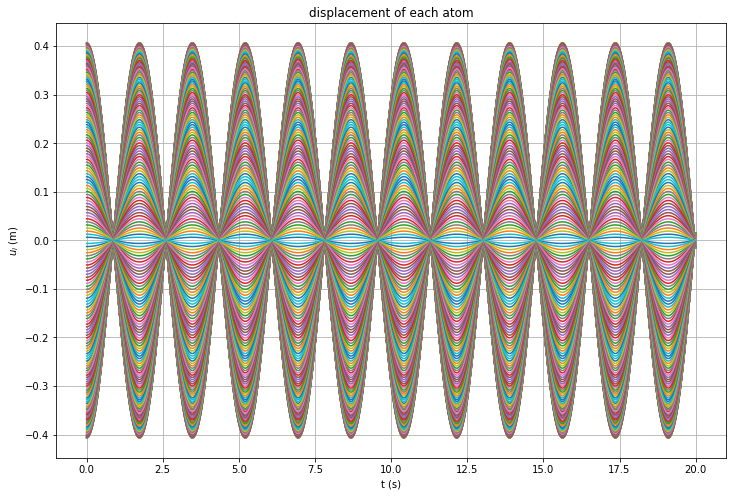

In [10]:
u = plotmode(1,omegas,a)

In [11]:
#create animation
filename = 'mode1.mp4'
animate_matplotlib(filename, u, 20)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:53<00:00, 17.59it/s]


# Plot/Animate mode 3

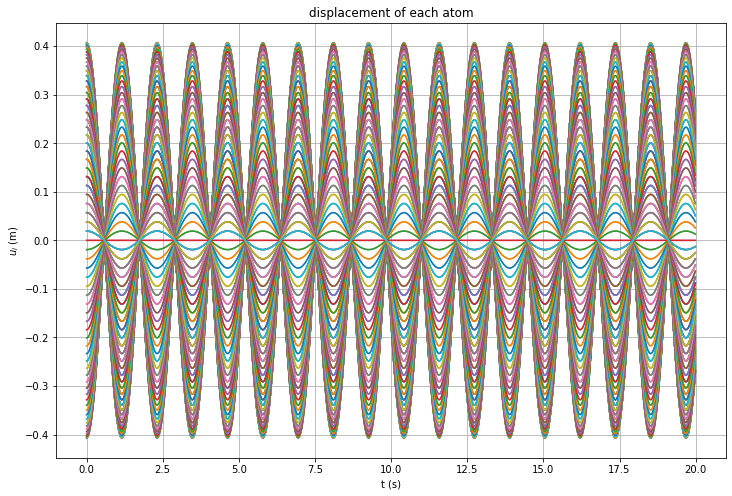

In [12]:
u = plotmode(2,omegas,a)

In [13]:
#create animation
filename = 'mode2.mp4'
animate_matplotlib(filename, u, 20)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:52<00:00, 17.75it/s]


# Plot/Animate mode 5

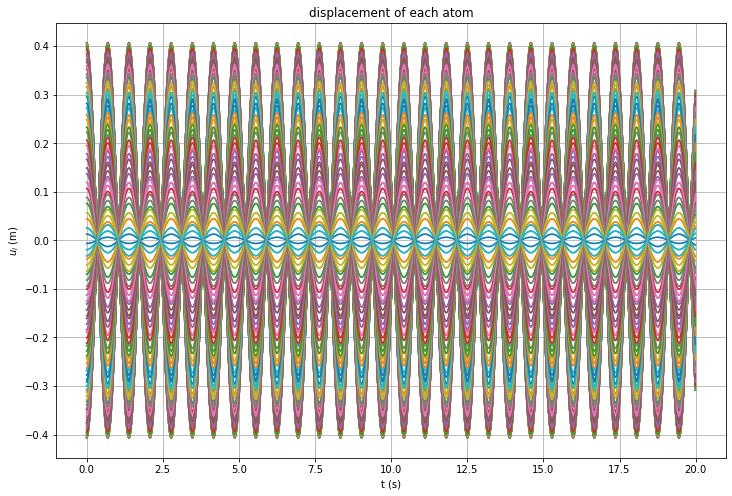

In [14]:
u = plotmode(4,omegas,a)

In [15]:
#create animation
filename = 'mode4.mp4'
animate_matplotlib(filename, u, 20)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:53<00:00, 17.62it/s]


# Plot/Animate mode 9

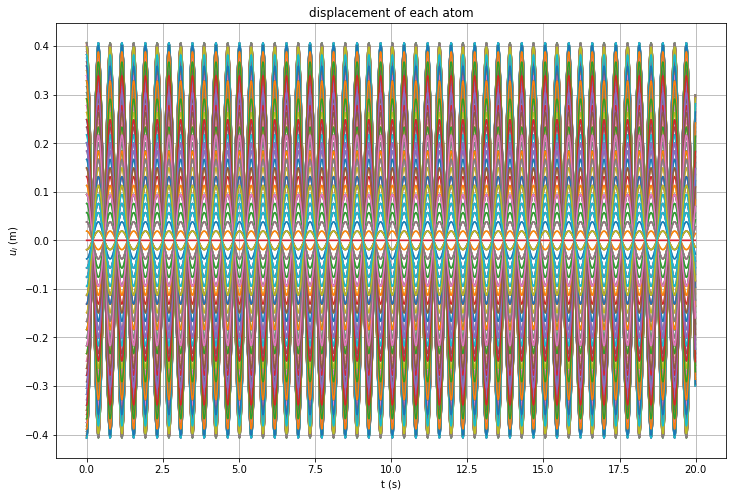

In [16]:
u = plotmode(8,omegas,a)

In [17]:
#create animation
filename = 'mode8.mp4'
animate_matplotlib(filename, u, 20)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:54<00:00, 17.52it/s]


# Plot/Animate mode 13

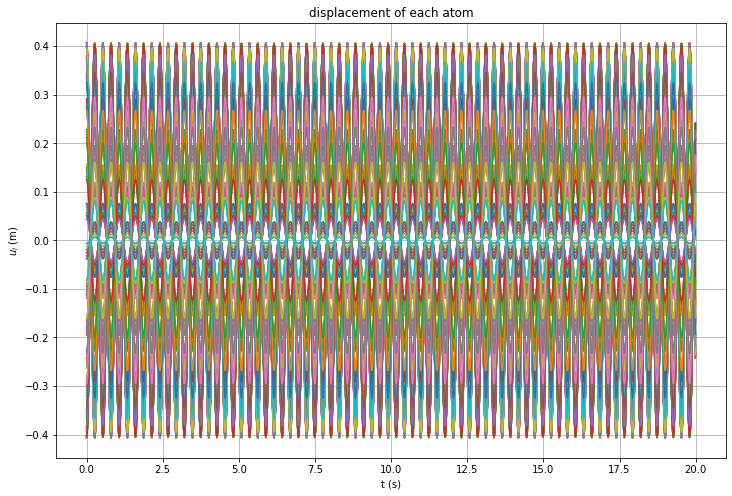

In [26]:
u = plotmode(12,omegas,a)

In [27]:
#create animation
filename = 'mode12.mp4'
animate_matplotlib(filename, u, 20)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:23<00:00,  9.80it/s]


# Plot/Animate mode 21

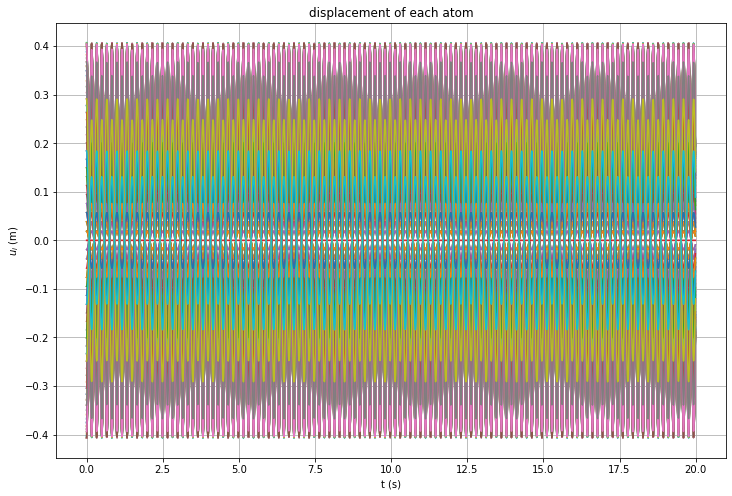

In [28]:
u = plotmode(20,omegas,a)

In [29]:
#create animation
filename = 'mode12.mp4'
animate_matplotlib(filename, u, 20)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:55<00:00, 17.39it/s]


# Plot/Animate mode 50

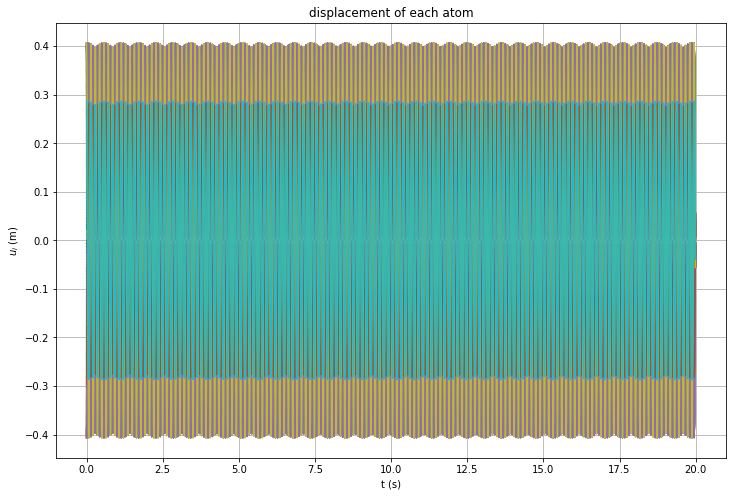

In [30]:
u = plotmode(49,omegas,a)

In [31]:
#create animation
filename = 'mode12.mp4'
animate_matplotlib(filename, u, 5)

#display animation
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:48<00:00,  3.78it/s]


## Conclusion

In this project, we modelled a circular ring that moves in a standing wave pattern. We determined that we must calculate for the atoms to move radially instead of on a linear path.

In general, our system models the different modes of standing waves with decent precision. This can be seen by the fixed points in the circle while other parts are still oscillating.